# Physical Risk Impact Model with Supply Chain Reallocation

The present notebook is an application of the model described in _Fahr 2024_, which computes the amplified impact of climate-related physical risk through Input-Output linkages, implementing a trade reallocation mechanism

#### Basic setup

In [3]:
# Physical Risk Propagation Model - main.ipynb
# 
# Orchestrates:
#  - Loading latest EU-27 SAM from Databricks
#  - Initialising IOClimateModel
#  - Running physical risk propagation until convergence
#  - Inspecting and exporting results

import os
import sys

# If notebook is at project/main.ipynb and src/ is project/src/
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd()))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")

if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

# Standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Spark (in Databricks, `spark` is usually already defined)
try:
    spark
except NameError:
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.appName("IOClimateModel").getOrCreate()

spark


#### Utils import

In [4]:
from data_io.eurostat_sam import load_sam_latest_year, extract_model_inputs_from_sam
from io_climate.model import IOClimateModel
from io_climate.scenarios import make_shock_vectors

# if you want to test pure functions directly at some point:
# from io_climate.propagation import propagate_once, update_demand



- The model is applied to the EU27 Multi-Country Social Accounting Matrix, comprising 63 productive sectors.
- The SAM table is retrieved through an ingestion from the "stage" Databricks catalog, in the "gold" version.
- The latest available SAM is automatically retrieved.
- For the sake present model, specific blocks of the SAM are extracted.


In [5]:
# Load latest SAM
sam_df, latest_year = load_sam_latest_year(spark)
print("SAM year:", latest_year)
print("SAM df rows:", sam_df.count())


# Extract model inputs
Z, FD, X, A, globsec_of, node_labels = extract_model_inputs_from_sam(sam_df)


print("n (nodes):", Z.shape[0])
print("Z shape:", Z.shape)
print("FD shape:", FD.shape)
print("X shape:", X.shape)
print("A shape:", A.shape)



SAM year: 2022
SAM df rows: 2040159
n (nodes): 1695
Z shape: (1695, 1695)
FD shape: (1695,)
X shape: (1695,)
A shape: (1695, 1695)


The model is implemented thorugh a python class which contains the simulation and trade reallocation routines.

In [6]:
model = IOClimateModel(
    Z=Z,
    FD=FD,
    X=X,
    globsec_of=globsec_of,
    A=A,  # use the precomputed A
)


Demand and supply shocks are defined for countries and sectors in % points.

In [7]:
sd, sp = make_shock_vectors(
    node_labels=node_labels,
    country_codes=["IT"],
    sector_codes=["P_C10-12", "P_C13-15", "P_C16"],
    supply_shock_pct=5,
    demand_shock_pct=0
)


Next the simulation is executed, with the possibility of changing the gamma parameter (trade reallocation capacity) as well as maximum iterations number and tolerance.

In [8]:
results = model.run(
    sd=sd,
    sp=sp,
    gamma=1,                 # you can tweak later
    max_iter=500,
    tol=1e-5,
    demand_update_mode="supply_limited",
    return_history=True,
)

print("Converged:", results["converged"])
print("Iterations:", results["iterations"])


Converged: True
Iterations: 229


In [9]:

X_baseline = model.X
X_shocked = results["X_final"]

loss_pct = (X_shocked - X_baseline) / (X_baseline + 1e-12) * 100.0

rows = []
for i, label in enumerate(node_labels):
    country, sector = label.split("::", 1)
    rows.append({
        "node": label,
        "country": country,
        "sector": sector,
        "X_baseline": X_baseline[i],
        "X_shocked": X_shocked[i],
        "loss_pct": loss_pct[i],
    })

df_impacts = pd.DataFrame(rows)
df_impacts.head()


,node,country,sector,X_baseline,X_shocked,loss_pct
0,AT::P_A01,AT,P_A01,10170.862001,9687.067543,-4.756671
1,AT::P_A02,AT,P_A02,2903.627000,2780.572551,-4.237957
2,AT::P_A03,AT,P_A03,111.881000,107.000082,-4.362598
3,AT::P_B,AT,P_B,3452.811000,3362.663852,-2.610834
4,AT::P_C10-12,AT,P_C10-12,28074.827001,27177.319787,-3.196840


In [10]:
top_losses = (
    df_impacts
    .sort_values("loss_pct")   # most negative first
    .head(20)
)

top_losses


,node,country,sector,X_baseline,X_shocked,loss_pct
948,IT::P_C10-12,IT,P_C10-12,153477.799005,79594.747246,-48.139244
950,IT::P_C16,IT,P_C16,17018.790001,11594.754933,-31.870862
949,IT::P_C13-15,IT,P_C13-15,63150.357004,47877.225093,-24.185345
944,IT::P_A01,IT,P_A01,68065.755004,53210.711206,-21.824549
505,EL::P_A03,EL,P_A03,925.901000,854.814684,-7.677529
1569,SI::P_A01,SI,P_A01,1633.930000,1514.304103,-7.321360
552,EL::P_N77,EL,P_N77,1496.733000,1400.050885,-6.459543
237,CY::P_N77,CY,P_N77,272.232000,255.328686,-6.209158
1575,SI::P_C16,SI,P_C16,1150.996000,1080.851282,-6.094263
548,EL::P_M71,EL,P_M71,3620.673000,3400.931764,-6.069072


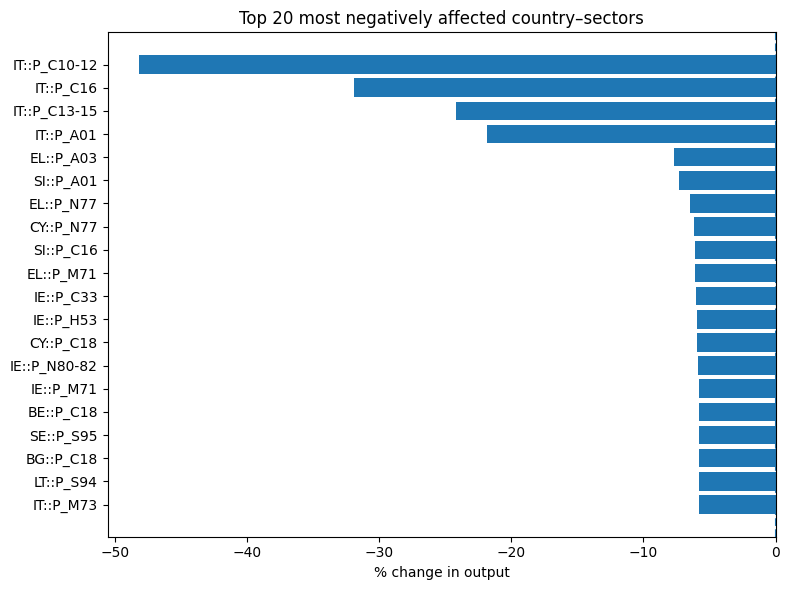

In [11]:

plt.figure(figsize=(8, 6))
plt.barh(
    top_losses["node"],
    top_losses["loss_pct"]
)
plt.axvline(0, linestyle="--")
plt.xlabel("% change in output")
plt.title("Top 20 most negatively affected country–sectors")
plt.gca().invert_yaxis()  # so worst at top
plt.tight_layout()
plt.show()
